### Practica Neuroevolucion

## Integrantes

- Juan Jose Urioste
- Carlos Huerta Garcia
- Alejo Torres Teruel


## Instalación

!pip install gymnasium  
!pip install gymnasium[box2d] 

## Acciones adicionales

### En macos

pip uninstall swig  
xcode-select -—install (si no se tienen ya)  
pip install swig  
pip install 'gymnasium[box2d]' # en zsh hay que poner las comillas  

### en Windows

Si da error, se debe a la falta de la versión correcta de Microsoft Visual C++ Build Tools, que es una dependencia de Box2D. Para solucionar este problema, puede seguir los siguientes pasos:  
 * Descargar Microsoft Visual C++ Build Tools desde https://visualstudio.microsoft.com/visual-cpp-build-tools/.
 * Dentro de la app, seleccione la opción "Herramientas de compilación de C++" para instalar.
 * Reinicie su sesión en Jupyter Notebook.
 * Ejecute nuevamente el comando !pip install gymnasium[box2d] en la línea de comandos de su notebook.

 ## Utilizando un Contenedor de Docker
1. instalar WSL2 -> Es importante que sea la version 2 -> https://learn.microsoft.com/es-es/windows/wsl/install
2. decargar y configurar docker desde la pagina oficial https://docs.docker.com/desktop/install/windows-install/ -> desde la aplicacion de escritorio de docker (DockerDesktop) indicar en configuracion que se utilizara el backend de docker en **WSL2**
3. Instalar VSCode
4. dentro de VSCode instalar la extension de remote containers
5. Dentro de una nueva carpeta copiar y pegar la carpeta de *.devcontainer* y el archivo *requirements.txt*

El archivo *.devcontainer.json* describe una abstraccion por encima del conteneder de docker llamadas devcontainers, dentro estan especificados todos los comandos para instalar las dependencias necesarias del entorno, la imagen base y los usuarios remotos (dentro se pueden especificar todas las cosas que encontrarias normalmente en un fichero docker)

6. Por ultimo reinciar VSCode dentro de la carpeta en cuestion o correr el comando *>Reopen in Container* dentro del editor -> (Con la tecla F1 abren la paleta de comandos) La segunda vez que lo abran deberia darles un alert con una opcion de re-abrir dentro del contenedor

**Nota:** Si estas utilizando la ultima version de WSL2 en windows,no deberias realizar ninguna configuracion adicional para exponer la direccion del Display de tu ordenador en el contenedor, ya que esta se hace automaticamente. En caso de ser necesario, referirse a [este enlace](https://aalonso.dev/blog/how-to-use-gui-apps-in-wsl2-forwarding-x-server-cdj)

## Estructura del proyecto
En este Notebook se detallan las implementaciones pedidas en la practica. Ademas se incluyen los archivos .py con el codigo para ser ejecutados individualmente.

Archivo | Descripcion
---|---
entrega.ipynb | Notebook con las implementaciones pedidas en la practica
Multilayer.py | Implementacion del perceptron multicapa
playable.py | Implementacion para controlar el agente con el teclado
rules.py | Implementacion de la policy usando un sistema experto basado en reglas
/images | Carpeta con imagenes de los resultados de la practica
/salga/neuroevolution | entrenamiento por neuroevolucion del LunarLander para ser cargado en salga
/salga/walker | entrenamiento por neuroevolucion del BipedalWalker para ser cargado en salga
.devcontainer | Carpeta con los archivos para la configuracion del entorno de desarrollo
requirements.txt | Archivo con las dependencias necesarias para el entorno de desarrollo

In [35]:
from Multilayer import Multilayer  #! Modelo de AAII
import gymnasium as gym
import numpy as np
import gymnasium as gym
import pygame

# Control Manual

una implementacion que permite controlar el agente con el teclado utilizando *EventListeners* de **Pygame**

In [14]:
# prueba lunar lander por humano
# apartado A de la práctica

env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()


done = False
while True:
    env.render()
    action = 0 
    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_LEFT:
                action = 3
            elif event.key == pygame.K_RIGHT:
                action = 1
            elif event.key == pygame.K_UP:
                action = 2
            else:
                action = 0 
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        done = True
        break

env.close()

# Usando Reglas de Control

intentamos controlar el Lunar Lander usando un sistema experto basado en reglas, podemos notar que su rendimiento no es muy bueno

In [15]:
class ExpertSystem:
  def __init__(self, observation):
    x, y, vx, vy, angle, angular_velocity, left_leg, right_leg = observation
    self.isRotating = abs(angular_velocity) > 0.15
    self.isMoving = abs(vx) > 0.15
    self.isLeaving = vy > 0.15
    self.isLeft = x < -0.15
    self.isRight = x > 0.15
    self.isForward = angle > 0.3
    self.isBackward = angle < -0.3
    self.isAtBase = y < 0.025
    self.isUp = y < 0.8 and vy < -0.025
    self.won = left_leg == 1 and right_leg == 1 and self.isAtBase and not self.isLeft and not self.isRight

def step(observation):
  rules = ExpertSystem(observation)
  if rules.won:
    return 0, True
  if not rules.isAtBase and rules.isUp and not rules.isLeaving:
    return 2, False
  if rules.isRotating:
    if rules.isForward:
      return 3, False
    elif rules.isBackward:
      return 1, False
  if rules.isMoving:
    if rules.isRight:
      return 3, False
    else:
      return 1, False
  return 0, False
    
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()
count = 0
while(count < 10):
    action,won = step(observation)  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
      count += 1
      if won: print("Landed!")
      observation, info = env.reset()
env.close()

Landed!
Landed!


## Notas
Las observaciones que el agente obtiene del entorno son las siguientes:
```python
 x, y, vx, vy, angle, vangle, left_leg, right_leg = observation
 ```

- x, y: Posición del centro de masa del agente.
- vx, vy: Velocidad del centro de masa del agente.
- angle: Ángulo de la dirección del agente.
- vangle: Velocidad angular del agente.
- left_leg, right_leg: indicadores si el agente esta tocando el suelo.

Las acciones posibles son:
[nada, derecho, central, izquierdo]
## Esquema
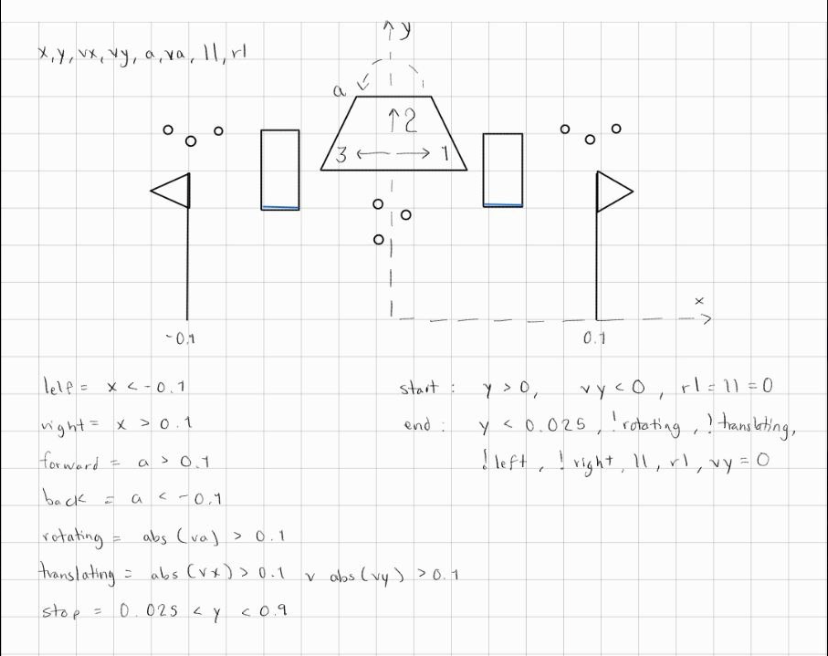

# Neuroevolucion

Utilizaremos un algortimo genetico para entrenar los pesos de un perceptron multicapa que sera el encargado de tomar las decisiones del agente.

Usaremos la Implementacino de MLP usada en la practica 1 de AAII


Agregamos 2 metodos nuevos a la clase Multilayer para poder cargar y guardar los pesos de la red neuronal apartir del cromosoma.
  
  ```python
   def from_chromosome(self, chromosome):
        self.W1 = np.array(chromosome[:self.ninput*self.nhidden]).reshape(self.W1.shape)
        chromosome = chromosome[self.ninput*self.nhidden:]
        self.b1 = np.array(chromosome[:self.nhidden])
        chromosome = chromosome[self.nhidden:]
        self.W2 = np.array(chromosome[:self.nhidden*self.noutput]).reshape(self.nhidden, self.noutput)
        chromosome = chromosome[self.nhidden*self.noutput:]
        self.b2 = np.array(chromosome[:self.noutput])
  ```
a partir de un cromosoma, que en este caso es de longitud fija(aunque podriamos implementarlo de forma que la arquitectura de la red tambien varia y por ende la forma de cromosoma tambien) reconstruimos las matrices de pesos y vectores de bias para la arquitectura definida en un principio, valiendonos del numero de neuronas en la capa de entrada, en la capa oculta y en la salida

```python
    def to_chromosome(self):
        return np.concatenate((self.w1.flatten(), self.b1.flatten(), self.w2.flatten(), self.b2.flatten()))
```

y a la inversa, a partir de las matrices de pesos y vectores de bias, construimos un cromosoma que sera el que se guarde en la poblacion,aplanando los tensores de numpy.


A continuacion se describe el codigo que sera cargado en salga para ejecutar el algoritmo genetico

In [ ]:
# neuroevolución
from Multilayer import Multilayer
CHROMSIZE = 8 * 6 + 6 + 6 * 4 + 4 #! numero de pesos y bias
N = 10  # number of episodes to average


env = gym.make("LunarLander-v2")  # fitness environment
model = Multilayer(8, 6, 4)  # 8 inputs, 6 hidden neurons, 4 outputs


# phenotype environment
graphical_env = gym.make("LunarLander-v2", render_mode="human")
phenotype_model = Multilayer(8, 6, 4)


def step(env, model, observation) -> tuple:
    env.render()
    action = model.inference(observation)
    observation, reward, terminated, truncated, info = env.step(
        np.argmax(action))
    return observation, reward, terminated, truncated, info


def phenotype(chromosome):
    observation, info = graphical_env.reset()
    phenotype_model.from_chromosome(chromosome)
    observation, info = graphical_env.reset()
    partial_reward = 0
    while True:
        observation, reward, terminated, truncated, info = step(
            graphical_env, phenotype_model, observation)
        partial_reward += reward
        if terminated or truncated:
            break
    return f'reward: {partial_reward}'


def fitness(chromosome):
    model.from_chromosome(chromosome)
    observation, info = env.reset()
    total_reward = 0
    for _ in range(N):
        partial_reward = 0
        while True:
            observation, reward, terminated, truncated, info = step(
                env, model, observation)
            partial_reward += reward
            if terminated or truncated:
                break
        partial_reward += 600  # add 600 points for each episode
        partial_reward /= 1200  # normalize to [0, 1]
        total_reward += partial_reward
    env.close()
    return total_reward / N if total_reward > 0 else 0


parameters = {'alphabet': [-12, 12], 'type': 'floating', 'norm': True, 'chromsize': CHROMSIZE,
                'pmut': 1./(CHROMSIZE), 'popsize': 100, 'trace': 10, 'tournament': 4}


# Fitness
Se carga el modelo desde el cromosoma y se reestablece el entorno de entrenamiento, se obtiene la recompensa media para N intentos normalizando para evitar la pérdida de información
# Fenotipo
Se carga el modelo desde el cromosoma, se reestablece el entorno gráfico y se realiza la ejecución con la inferencia obtenida a partir del cromosoma con el mejor fitness.
## Paso
En cada paso se obtiene la inferencia del modelo cargado para la acción a realizar en el entorno

 ## MEJORES PESOS PARA LA RED

 a continuacion se describen los mejores pesos para la red obtenidos del entrenamiento por medio del algortimo genetico 


In [17]:
chromosome = [2.794501919975321, 2.875661568940633, -2.930526697536426, -0.9255662809584678, 2.1960126225110126, 2.8889617129812555, 3.7414021462385225, -1.280778705529883, 4.809377038688804, -2.833739299533354, 0.5385204799685158, -4.610514946763439, 1.4391542959817782, 3.1067259038376616, -3.585780236691698, 0.19716388668747656, 0.7499783105121457, 0.469673988281562, 6.014301999934148, -2.7135801825295336, -0.6386726956709784, -0.23985203155632373, -2.495469888845168, 2.933981913068642, -2.4378718212268673, -7.080081838562344, 2.2275043696051697, -1.4963061387741368, 1.914363137162466, 1.3028587758617907, -1.9087631281259283, -5.230539993459362, 0.23676001011038358, 0.9957350792572751, 0.8963078988156166, 3.777337674344667, -0.8435632687541459, -2.163595698056045, -2.018759571167102, 3.40960366023323, -0.9480900355088242, 2.3453430229861367, 5.329984659007474, -3.5007225393403645, 2.6794970537175735, 5.161108192725351, -2.040791884663567, 2.742355624771309, 1.1401726907992236, 0.16608743473527013, 6.364518226295927, -4.574587310271477, 7.816144543108642, -3.4612171223251393, 5.548575029570313, 2.2830604924543825, -7.83486594636597, -0.6560075696345925, -5.38466544700564, 3.7696179218246786, 4.2808894822475985, -3.9280900399417833, 0.2542704175157642, -1.325040021874688, -1.7596803496649551, 4.3202093661807055, 2.78466641309097, -1.7093157883296426, -2.2490594448830925, -2.876917430347236, -1.0922556431681725, -1.8357830893794636, 1.3198723804320454, -0.11916816120842683, -0.052922991313472736, -1.1184960012718872, -2.59501961116306, -2.1919308502979935, -4.926564255594259, -2.1677132523601705, 1.1768210445955096, -2.6234313777343248]

## Prueba del los pesos 

In [43]:
# prueba lunar lander por agente
 #! Modelo de AAII
env = gym.make("LunarLander-v2", render_mode="human")
model = Multilayer(8, 6, 4)
model.from_chromosome(chromosome)
def run ():
    observation, info = env.reset()
    ite = 0
    racum = 0
    while True:
        action = np.argmax(model.inference(observation))   
        observation, reward, terminated, truncated, info = env.step(action)
        
        racum += reward

        if terminated or truncated:
            r = (racum+600) / 1200
            print(racum, r)
            return racum
    
run()

265.0711975810631 0.7208926646508859


265.0711975810631

## Conclusiones

Como estamos trabajando con numeros reales, utilizamos los operadores correspondientes que ya se encuentran implementados en salga.

Definimos el alfabeto dentro de un rango, en nuestro caso [-12,12]. ya que entre [-1,1] no obteniamso pesos los suficientemente fuertes para entrenar correctamente la red

Realizamos N repeticiones del entorno con cada cromosoma, para luego tomar un promedio de sus rewards, esto debido a que el entorno es cambiante y de esta manera mitigamos un poco el factor suerte

Por ultimo normalizamos la recompensa obtenida sumandole 600 y dividiendo por  1200 para evitar tener fitness negativos, lo que nos ocacionaba problemas al momento de iniciar el proceso de aprendizaje


![./images/download1.png](./images/download1.png)
![./images/download2.png](./images/download2.png)

![./images/download3.png](./images/download3.png)

![./images/download4.png](./images/download4.png)



# Opcional: BipedalWalker
Se definen las funciones fitness y phenotype para la implementación del BipedalWalker utilizando neuroevolución.

In [ ]:
import gymnasium as gym
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
from Multilayer import Multilayer

CHROMSIZE = 24 * 6 + 6 + 6 * 4 + 4
N = 10  # number of episodes to average


env = gym.make("BipedalWalker-v3")  # fitness environment
model = Multilayer(24, 6, 4)  # 8 inputs, 6 hidden neurons, 4 outputs


# phenotype environment
graphical_env = gym.make("BipedalWalker-v3",render_mode="human")
phenotype_model = Multilayer(24, 6, 4)


def step(env, model, observation) -> tuple:
    env.render()
    action = model.inference(observation)
    observation, reward, terminated, truncated, info = env.step(
     action.flatten().tolist())
    return observation, reward, terminated, truncated, info


def phenotype(chromosome):
    observation, info = graphical_env.reset()
    phenotype_model.from_chromosome(chromosome)
    observation, info = graphical_env.reset()
    partial_reward = 0
    while True:
        observation, reward, terminated, truncated, info = step(
            graphical_env, phenotype_model, observation)
        partial_reward += reward
        if terminated or truncated:
            break
    return f'reward: {partial_reward}'


def fitness(chromosome):
    model.from_chromosome(chromosome)
    observation, info = env.reset()
    total_reward = 0
    for _ in range(N):
        partial_reward = 0
        while True:
            observation, reward, terminated, truncated, info = step(
                env, model, observation)
            partial_reward += reward
            if terminated or truncated:
                break
        partial_reward += 400  # add 600 points for each episode
        partial_reward /= 700 # normalize to [0, 1]
        total_reward += partial_reward
    env.close()
    return total_reward / N if total_reward > 0 else 0


parameters = {'alphabet': [-12, 12], 'type': 'floating', 'norm': True, 'chromsize': CHROMSIZE,
              'pmut': 1./(CHROMSIZE), 'popsize': 100, 'trace': 10, 'tournament': 4}
